In [1]:
import subprocess
import os, random, re, json, numbers, sys
sys.path.append("../scripts")
from helper import *
from tqdm import tqdm
from pprint import pprint
import pytz
from datetime import datetime
timezone = pytz.timezone('America/New_York') 
from collections import Counter, defaultdict
import numpy as np
import pandas as pd
pd.set_option('display.float_format', '{:.4f}'.format)


In [2]:
output = subprocess.run(
    ['python', 
     '../scripts/output_program.py',  ''], 
    stdout=subprocess.PIPE, 
    stderr=subprocess.STDOUT, 
    universal_newlines=True,
) 
#type(output) == subprocess.CompletedProcess

In [2]:
iid_test = [json.loads(l) for l in open("../data/lila/multi/iid/test.json", "r").readlines()]
ood_test = [json.loads(l) for l in open("../data/lila/multi/ood/test.json", "r").readlines()]
tmp = json.load(open("../data/lila/single_number_ans_ids.json", "r"))
iid_selected_ids, ood_selected_ids = tmp['iid_test'], tmp['ood_test']

In [4]:
i = 67
print(iid_test[i]['Input'])
print(iid_test[i]['Output Answer'])

Which is the biggest value?  (a) -2  (b) -62  (c) 82
['82']


In [3]:
def get_program_stdout(outputs, time_limit=10):
    ## Postprocess output to extract answer spans
    try:
        p = outputs.split("\nAnswer: ")[0]
        p = p.split("```")[1]
    except: return "PostprocessingError"
    
    ## Execute program with a timer
    try: 
        output = subprocess.run(
            ["python", '-c', p], 
            stdout=subprocess.PIPE, 
            stderr=subprocess.STDOUT, 
            universal_newlines=True,
            timeout=time_limit
        )
        return output.stdout.strip()
    except subprocess.SubprocessError: return "TimeoutError"
    
def EM(pred, gth):
    # check if ratio pred/gth \in [0.999, 1.001]
    # This would give credits to fractions, e.g. 1/7 = 0.1428
    gth = float(gth)
    if gth == 0: return pred == gth
    return np.absolute(pred/gth - 1) <= 0.001
    

In [4]:
output_llm_folder = "../data/output_decoder_LM/vicuna-13b"
output_llm_files = sorted(os.listdir(output_llm_folder))

output_llm_lines = []
for file in output_llm_files[:8]:
    with open(os.path.join(output_llm_folder, file), "r") as f:
        output_llm_lines.extend(f.readlines()[1:])
print(len(output_llm_lines))

5342


In [30]:
# Save execution output to anther file
date = datetime.now(timezone).strftime("%m%d_%H%M%S")
with open(f"../data/program_eval/vicuna-13b/lila_iid_test_single_number_ans_postprocessingerror_re-gen_{date}.jsonl", "w") as f:
    for l in tqdm(output_llm_lines[:]):
        i, outputs = list(json.loads(l).items())[0]
        f.write(json.dumps({i:get_program_stdout(outputs)})+"\n")


100%|██████████| 293/293 [00:41<00:00,  7.01it/s]


#### Re exec some output programs after installing scipy

In [5]:
llm_rel_path = "vicuna-13b"

exec_ans_d = json.load(open(f"../data/lila/results/{llm_rel_path}/iid_test_single_ans_exec_ans_types.json", "r"))
ids = exec_ans_d["ModuleNotFoundError"]
print(len(ids))

output_llm_folder = f"../data/output_decoder_LM/{llm_rel_path}"
output_llm_files = sorted(os.listdir(output_llm_folder))

output_llm_lines = []
for file in output_llm_files[:8]:
    with open(os.path.join(output_llm_folder, file), "r") as f:
        output_llm_lines.extend(f.readlines()[1:])
print(len(output_llm_lines))

date = datetime.now(timezone).strftime("%m%d_%H%M%S")
with open(f"../data/program_eval/{llm_rel_path}/lila_iid_test_single_number_ans_{date}_reexec_after_install_scipy.jsonl", "w") as f:
    for l in tqdm(output_llm_lines[:]):
        i, outputs = list(json.loads(l).items())[0]
        if i in ids:
            f.write(json.dumps({i:get_program_stdout(outputs)})+"\n")


42
5342


100%|██████████| 5342/5342 [00:06<00:00, 840.30it/s]  


In [6]:
## Merge new program outputs with old file
with open(f"../data/program_eval/{llm_rel_path}/lila_iid_test_single_number_ans_0912_163559.jsonl", "r") as f:
    old = {}
    for l in f.readlines():
        d = json.loads(l)
        k = list(d.keys())[0]
        old[k] = d[k]
with open(f"../data/program_eval/{llm_rel_path}/lila_iid_test_single_number_ans_0919_201740_reexec_after_install_scipy.jsonl", "r") as f:
    new = {}
    for l in f.readlines():
        d = json.loads(l)
        k = list(d.keys())[0]
        new[k] = d[k]
print(len(old),len(new))
with open(f"../data/program_eval/{llm_rel_path}/lila_iid_test_single_number_ans_merge_0912_163559_0919_201740.jsonl", "w") as f:
    for i, o in old.items():
        if i in new: outputs = new[i]
        else: outputs = old[i]
        f.write(json.dumps({i:outputs})+"\n")

5342 42


#### Categorize exec outputs

In [8]:
# Eval execution outputs
output_execution_folder = "../data/program_eval/vicuna-13b"
output_execution_files = sorted(os.listdir(output_execution_folder))

output_execution_lines = []
for file in output_execution_files[2:3]:
    print(file)
    with open(os.path.join(output_execution_folder, file), "r") as f:
        output_execution_lines.extend(f.readlines())
print(len(output_execution_lines))

lila_iid_test_single_number_ans_merge_0912_163559_0919_201740.jsonl
5342


In [9]:
# Categorize execution outputs

exec_ans_d = defaultdict(list)
for l in tqdm(output_execution_lines):
    i, o = list(json.loads(l).items())[0]
    
    if "SyntaxError: invalid syntax" in o:
        exec_ans_d['SyntaxError'].append(i)
        continue
    match = re.findall(r'(?P<errortype>[A-Z].*Error)', o)
    if len(match): 
        exec_ans_d[match[-1]].append(i)
        continue
    
    cate, a = find_num_from_str(o)
    exec_ans_d[cate].append((i, a))

print(f"Categorized {sum([len(v) for v in exec_ans_d.values()])} direct answer outputs")
for k, v in exec_ans_d.items():
    print(k, len(v))

100%|██████████| 5342/5342 [00:00<00:00, 165499.41it/s]

Categorized 5342 direct answer outputs
String 139
Number 4188
NameError 288
SyntaxError 424
TypeError 68
IndentationError 13
IndexError 2
AttributeError 33
MultiNumbers 141
OverflowError 3
TimeoutError 4
ZeroDivisionError 3
ValueError 4
NotImplementedError 1
ModuleNotFoundError 23
ImportError 8


In [10]:
## Eval execution outputs that are numbers
exec_ans_em = defaultdict(int)
for i, o in exec_ans_d['Number']:
    gth = iid_test[int(i)]['Output Answer'][0]
    if EM(o, gth):
       exec_ans_em[i] = 1
print(sum(exec_ans_em.values()))
for i, o in exec_ans_d['MultiNumbers']:
    gth = iid_test[int(i)]['Output Answer'][0]
    if any([EM(x, gth) for x in o]):
        exec_ans_em[i] = 1
print(sum(exec_ans_em.values()))
exec_ans_d["EM"] = list(exec_ans_em.keys())

1053
1077


In [11]:
print("Overall EM = {} / 5342 = {}%".format(len(exec_ans_d["EM"]), len(exec_ans_d["EM"])/53.42))
de = len(exec_ans_d['Number']) + len(exec_ans_d['MultiNumbers'])
print("EM when output is number = {} / {} = {}%".format(len(exec_ans_d["EM"]), de, len(exec_ans_d["EM"])*100/de))

Overall EM = 1077 / 5342 = 20.160988393859977%
EM when output is number = 1077 / 4329 = 24.878724878724878%


In [11]:
## Categorize direct answer outputs
dir_ans_d = defaultdict(list)
for l in tqdm(output_llm_lines):
    gth = float(iid_test[int(i)]['Output Answer'][0])

    i, outputs = list(json.loads(l).items())[0]
    # Extract span for direct answer
    if not "Answer: " in outputs: 
        dir_ans_d["PostprocessingError"].append(i)
        continue
    
    try: 
        a = outputs.split("Answer: ")[1].split("\n\n")[0]
    except IndexError: 
        dir_ans_d["PostprocessingError"].append(i)
        continue

    cate, a = find_num_from_str(a)
    dir_ans_d[cate].append((i, a))

print(f"Categorized {sum([len(v) for v in dir_ans_d.values()])} direct answer outputs")
for k, v in dir_ans_d.items():
    print(k, len(v))

  0%|          | 0/5342 [00:00<?, ?it/s]

100%|██████████| 5342/5342 [00:00<00:00, 78458.88it/s]

Categorized 5342 direct answer outputs
Number 4853
PostprocessingError 293
String 23
MultiNumbers 173


In [12]:
## Eval direct answers that are numbers
dir_ans_em = defaultdict(int)
for i, o in dir_ans_d['Number']:
    gth = iid_test[int(i)]['Output Answer'][0]
    if EM(o, gth):
        dir_ans_em[i] = 1
print(sum(dir_ans_em.values()))
for i, o in dir_ans_d['MultiNumbers']:
    gth = iid_test[int(i)]['Output Answer'][0]
    if any([EM(x, gth) for x in o]):
        dir_ans_em[i] = 1
print(sum(dir_ans_em.values()))
dir_ans_d["EM"] = list(dir_ans_em.keys())

851
871


In [12]:
# Save categorized answers 
#json.dump(dir_ans_d, open(f"../data/lila/results/{llm_rel_path}/iid_test_single_ans_dir_ans_types.json", "w"))
json.dump(exec_ans_d, open(f"../data/lila/results/{llm_rel_path}/iid_test_single_ans_exec_ans_types.json", "w"))
#json.dump(dir_ans_d, open(f"../data/lila/results/{llm_rel_path}/iid_test_single_ans_dir_ans_types_without_program.json", "w"))


871 1076 1028


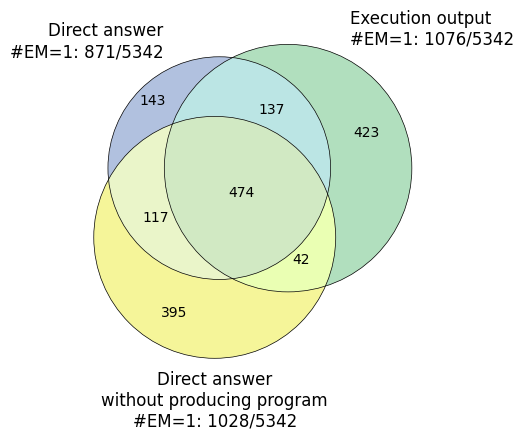

In [19]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn2_circles, venn3, venn3_circles

# Examine how often do different generation strategies agree
dir_ans_em_ids = json.load(open("../data/lila/results/iid_test_single_ans_dir_ans_types.json", "r"))["EM"]
dir_ans_without_program_em_ids = json.load(open("../data/lila/results/iid_test_single_ans_dir_ans_types_without_program.json", "r"))["EM"]
exec_ans_em_ids = json.load(open("../data/lila/results/iid_test_single_ans_exec_ans_types.json", "r"))["EM"]
print(len(dir_ans_em_ids), len(exec_ans_em_ids), len(dir_ans_without_program_em_ids))
venn3(
    [set(dir_ans_em_ids), set(exec_ans_em_ids), set(dir_ans_without_program_em_ids)],
    set_colors=('#3E64AF', '#3EAF5D', '#E6E600'), 
    set_labels = (
        f'Direct answer\n#EM=1: {len(dir_ans_em_ids)}/5342',
        f'Execution output\n#EM=1: {len(exec_ans_em_ids)}/5342',
        f'Direct answer\nwithout producing program\n#EM=1: {len(dir_ans_without_program_em_ids)}/5342',
    )
)
venn3_circles([set(dir_ans_em_ids), set(exec_ans_em_ids), set(dir_ans_without_program_em_ids)], lw=0.5)

plt.show()

In [50]:
# save post-processed results to csv
import csv
dir_ans_d = json.load(open("../data/lila/results/iid_test_single_ans_dir_ans_types.json", "r"))
dir_ans_without_program_d = json.load(open("../data/lila/results/iid_test_single_ans_dir_ans_types_without_program.json", "r"))
exec_ans_d = json.load(open("../data/lila/results/iid_test_single_ans_exec_ans_types.json", "r"))
rows = {}
for dir_ans_cate, ids in dir_ans_d.items():
    if dir_ans_cate == "EM": continue
    for x in ids:
        if isinstance(x, (tuple, list)):
            i, dir_ans = x
            gth = float(iid_test[int(i)]['Output Answer'][0])
            rows[i] = [i, gth, dir_ans, int(i in dir_ans_d["EM"])]
        else:
            gth = float(iid_test[int(x)]['Output Answer'][0])
            rows[x] = [x, gth, dir_ans_cate, 0]
for exec_ans_cate, ids in exec_ans_d.items():
    if exec_ans_cate == "EM": continue
    for x in ids:
        if isinstance(x, (tuple, list)):
            i, exec_ans = x
            rows[i].extend([exec_ans, int(i in exec_ans_d["EM"])])
        else:
            rows[x].extend([exec_ans_cate, 0])
for dir_ans_without_program_cate, ids in dir_ans_without_program_d.items():
    if dir_ans_without_program_cate == "EM": continue
    for x in ids:
        if isinstance(x, (tuple, list)):
            i, dir_ans_without_program = x
            rows[i].extend([dir_ans_without_program, int(i in dir_ans_without_program_d["EM"])])
        else:
            rows[x].extend([dir_ans_without_program_cate, 0])

rows = [x[1] for x in sorted(rows.items(), key=lambda x: int(x[0]))]
print(len(rows))

with open(f"../data/lila/results/{llm_rel_path}/iid_test_single_ans.csv", "w") as f:
    w = csv.writer(f, delimiter= ',')
    w.writerow(["id", "gth_ans", "output_dir_ans", "dir_ans_em", "exec_ans", "exec_ans_em", "output_dir_ans_without_program", "dir_ans_without_program_em"])
    for r in rows: w.writerow(r)


5342


In [51]:
results = pd.read_csv(
    f"../data/lila/results/{llm_rel_path}/iid_test_single_ans.csv", 
    header=0
    keep_default_na=False,
)
print(len(results))
results.head(30)

5342


,id,gth_ans,output_dir_ans,dir_ans_em,exec_ans,exec_ans_em,output_dir_ans_without_program,dir_ans_without_program_em
0,0,370.0000,37.0,0,(a) is the biggest value,0,370,1
1,1,-5.0000,0.5300000000000001,0,-3.4,0,w,0
2,2,0.0045,0.2,0,-0.2222222222222222,0,0.2,0
3,3,0.0000,-0.13,0,NameError,0,-0.13,0
4,4,1.0200,1.02,1,SyntaxError,0,-0.463768115942029,0
5,5,-6.0000,0.4,0,-6,1,0.6666666666666666,0
6,6,0.5000,4,0,0.5,1,x,0
7,7,5.0000,1.3333333333333333,0,106.26666666666667,0,(b) s,0
8,8,0.2000,13,0,TypeError,0,0.2,1
9,9,1.5800,2.0,0,1.58,1,2.0,0
